Installing Reqs

mamba create -n diffdock python=3.10 ; mamba activate diffdock
mamba install -y pytorch==1.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia && \
mamba install -y -c conda-forge openmm swig pdbfixer openbabel smina fpocket vina && \
mamba install -y -c bioconda pyrsistent foldseek &&\
mamba install -y -c pyg pyg=2.3.1=py310_torch_1.13.0_cu117 pytorch-cluster=1.6.1=py310_torch_1.13.0_cu117 pytorch-sparse=0.6.17=py310_torch_1.13.0_cu117 pytorch-scatter=2.1.1=py310_torch_1.13.0_cu117 && \
mamba install -y -c bioconda -c "dglteam/label/cu117" dgl && \
mamba install -y -c conda-forge ipykernel
pip install ipython-autotime --quiet

cd /mnt/nvme0/jbok/docking && git clone https://github.com/gcorso/DiffDock.git
cd DiffDock && git checkout a6c5275 

Installing SMINA/GINA

In [32]:
# %cd /mnt/nvme0/jbok/docking/DiffDock
# !wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
# !wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/mnt/nvme0/jbok/docking/DiffDock
--2023-11-14 21:34:22--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.37.111, 172.64.150.145, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.37.111|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlU-feaNuD2bmLWuiv0JjdITWI-vv7U17EP8tkTf6W93SfhQMuO7D8icoC9mIYs8-AC0hHyCDAewKXsHKICr2O4PpHtg%3D%3D&use_mirror=versaweb&r= [following]
--2023-11-14 21:34:22--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlU-feaNuD2bmLWuiv0JjdITWI-vv7U17EP8tkTf6W93SfhQMuO7D8icoC9mIYs8-AC0hHyCDAewKXsHKICr2O4PpHtg%3D%3D&use_mirror=versaweb&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, a

Utility functions

In [2]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [2]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet
    # not diffdock-specific:
    !pip install prolif --quiet # no real version??
    !pip install py3dmol==2.0.3 --quiet

In [3]:
import torch
print(torch.__version__)

# try:
#     import torch_geometric
# except ModuleNotFoundError:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#     !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
#     !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
#     !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
#     !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

1.13.1


/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


if not os.path.exists("/mnt/nvme0/jbok/docking/DiffDock/esm"):
    !cd /mnt/nvme0/jbok/docking/DiffDock
    !git clone https://github.com/facebookresearch/esm
    !cd /mnt/nvme0/jbok/docking/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    !cd ..

In [31]:
PDB_id = '7KI0'
SMILES_or_pubchem_id = 'CCC(C)C(C(=O)NC(C)C(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)NC(CCCNC(=N)N)C(=O)NCC(=O)NC(CCCNC(=N)N)C(=O)NCC(=O)O)NC(=O)C(CC3=CC=CC=C3)NC(=O)C(CCC(=O)O)NC(=O)C(CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CCC(C(=O)O)NC(=O)CCCCCCCCCCCCCCCCC(=O)O)NC(=O)C(C)NC(=O)C(C)NC(=O)C(CCC(=O)N)NC(=O)CNC(=O)C(CCC(=O)O)NC(=O)C(CC(C)C)NC(=O)C(CC4=CC=C(C=C4)O)NC(=O)C(CO)NC(=O)C(CO)NC(=O)C(C(C)C)NC(=O)C(CC(=O)O)NC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(CC5=CC=CC=C5)NC(=O)C(C(C)O)NC(=O)CNC(=O)C(CCC(=O)O)NC(=O)C(C)(C)NC(=O)C(CC6=CN=CN6)N'
# PDB_id = '1FAP' #'AF-P42345-F1'
# SMILES_or_pubchem_id = 'C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)/C)OC'
download_results = True

# if not PDB_id or not SMILES_or_pubchem_id:
#     PDB_id = "6agt"
#     SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
#     print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/mnt/nvme0/jbok/docking/DiffDock/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

In [32]:
%cd /mnt/nvme0/jbok/docking/DiffDock
%pwd
!python datasets/esm_embedding_preparation.py --protein_ligand_csv tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/mnt/nvme0/jbok/docking/DiffDock


  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 9965.
  warnings.warn(
/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9985.
  warnings.warn(
/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10005.
  warnings.warn(
/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain N is discontinuous at line 10042.
  warnings.warn(
/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 10046.
  wa

In [33]:
%cd /mnt/nvme0/jbok/docking/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/mnt/nvme0/jbok/docking/DiffDock/esm
!python esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/mnt/nvme0/jbok/docking/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/mnt/nvme0/jbok/docking/DiffDock/esm
Transferred model to GPU
Read data/prepared_for_esm.fasta with 6 sequences
Processing 1 of 1 batches (6 sequences)


In [37]:
%cd /mnt/nvme0/jbok/docking/DiffDock
# CUDA_VISIBLE_DEVICES=7 
!python -m inference \
    --protein_path /mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/7KI0.pdb \
    --ligand "CCC(C)C(C(=O)NC(C)C(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)NC(CCCNC(=N)N)C(=O)NCC(=O)NC(CCCNC(=N)N)C(=O)NCC(=O)O)NC(=O)C(CC3=CC=CC=C3)NC(=O)C(CCC(=O)O)NC(=O)C(CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CCC(C(=O)O)NC(=O)CCCCCCCCCCCCCCCCC(=O)O)NC(=O)C(C)NC(=O)C(C)NC(=O)C(CCC(=O)N)NC(=O)CNC(=O)C(CCC(=O)O)NC(=O)C(CC(C)C)NC(=O)C(CC4=CC=C(C=C4)O)NC(=O)C(CO)NC(=O)C(CO)NC(=O)C(C(C)C)NC(=O)C(CC(=O)O)NC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(CC5=CC=CC=C5)NC(=O)C(C(C)O)NC(=O)CNC(=O)C(CCC(=O)O)NC(=O)C(C)(C)NC(=O)C(CC6=CN=CN6)N" \
    --out_dir results/testruns \
    --out_name glp1r-7KI0_semaglutide \
    --inference_steps 20 \
    --samples_per_complex 10 \
    --batch_size 6

    # --protein_ligand_csv tmp/input_protein_ligand.csv \
# --save_visualisation
# --num_workers 64 \

/mnt/nvme0/jbok/docking/DiffDock


loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings1065802701/heterographs.pkl
Number of complexes:  1
radius protein: mean 101.6787109375, std 0.0, max 101.6787109375
radius molecule: mean 14.699892044067383, std 0.0, max 14.699892044067383
distance protein-mol: mean 204.7713623046875, std 0.0, max 204.7713623046875
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data for the confidence model now.
loading data from memory:  data/cache_torsion_allatoms/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_atomRad5_atomMax8_esmEmbeddings1065802701/heterographs.pkl
Number of complexes:  1
radius protein: mean 101.6787109375, std 0.0, max 101.6787109375
radius molecule: mean 15.343777656555176, std 0.0, max 15.343777656555176
distance protein-mol: mean 204.5838623046875, std 0.0, max 204.5838623046875
rmsd matching: mean

Running GINA to estimate affinity

In [75]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
# from google.colab import files

%cd /mnt/nvme0/jbok/docking/DiffDock/results/user_predictions_small

results_dirs = ['/mnt/nvme0/jbok/docking/DiffDock/results/user_predictions_small/index0_-mnt-nvme0-jbok-docking-DiffDock-tmp-pdb-7ZUB.pdb____C1=CC=C2C(=C1)C=CN2']
# results_dirs = glob("/mnt/nvme0/jbok/docking/DiffDock/results/user_predictions_small/index*")
# print(results_dirs)

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    # print(results_dir)
    results_pdb_file = "/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/7ZUB.pdb"
    # results_pdb_file = "/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/" + results_dir + ".pdb"
    # results_pdb_file = "/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/mnt/nvme0/jbok/docking/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/mnt/nvme0/jbok/docking/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

/mnt/nvme0/jbok/docking/DiffDock/results/user_predictions_small


runs: 100%|██████████| 1/1 [07:56<00:00, 476.62s/it]


### Top hit by DiffDock confidence for any PDB/smiles combination

---



In [76]:
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
df_results.sort_values("diffdock_confidence", ascending=False)

pdb_file               smiles  diffdock_confidence  gnina_scored_affinity  \
44  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.24               -1.72828   
49  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.19               -2.89891   
38  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.16               -3.64141   
39  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.03                1.98672   
23  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.03               -1.71356   
22  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.03               -0.15838   
6   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                 0.00                3.74641   
24  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.01                1.71016   
8   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.02               -2.32451   
19  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.02               -1.26167   
17  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.04               -3.85106   
36  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.04               -0.02672   
42  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.05               -0.78485   
32  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.05               -0.17884   
25  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.05               -2.61993   
1   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.07               -1.00860   
9   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.08               -2.22426   
2   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.08               -2.39408   
13  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.09               -4.44226   
7   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.10               -3.34966   
28  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.15                0.21327   
46  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.16                2.60768   
47  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.17               -0.55515   
4   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.17               -1.59558   
21  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.20                0.70673   
18  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.21                2.96968   
12  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.21               -0.51488   
37  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.24                6.49990   
16  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.33               -3.93313   
15  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.38                2.24415   
45  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.40               -4.17294   
30  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.43               -2.55122   
41  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.47               -0.74926   
26  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.51                5.76357   
20  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.58                3.70358   
3   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.66                6.91491   
11  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -0.86               -3.60660   
31  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -1.52               40.28666   
5   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -1.69               15.61790   
34  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -1.91                7.66724   
14  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -2.22               -0.87983   
10  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -2.61               -0.83661   
35  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -2.68               12.94557   
0   7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -5.48               55.63392   
33  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -5.73               97.47663   
27  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -6.13               97.44171   
40  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -6.75              126.25342   
43  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2                -7.02               70.11531   
29  7ZUB.pdb  C1=CC=C2C(=C1)C=CN2  

## Compare gnina affinities with DiffDock confidences

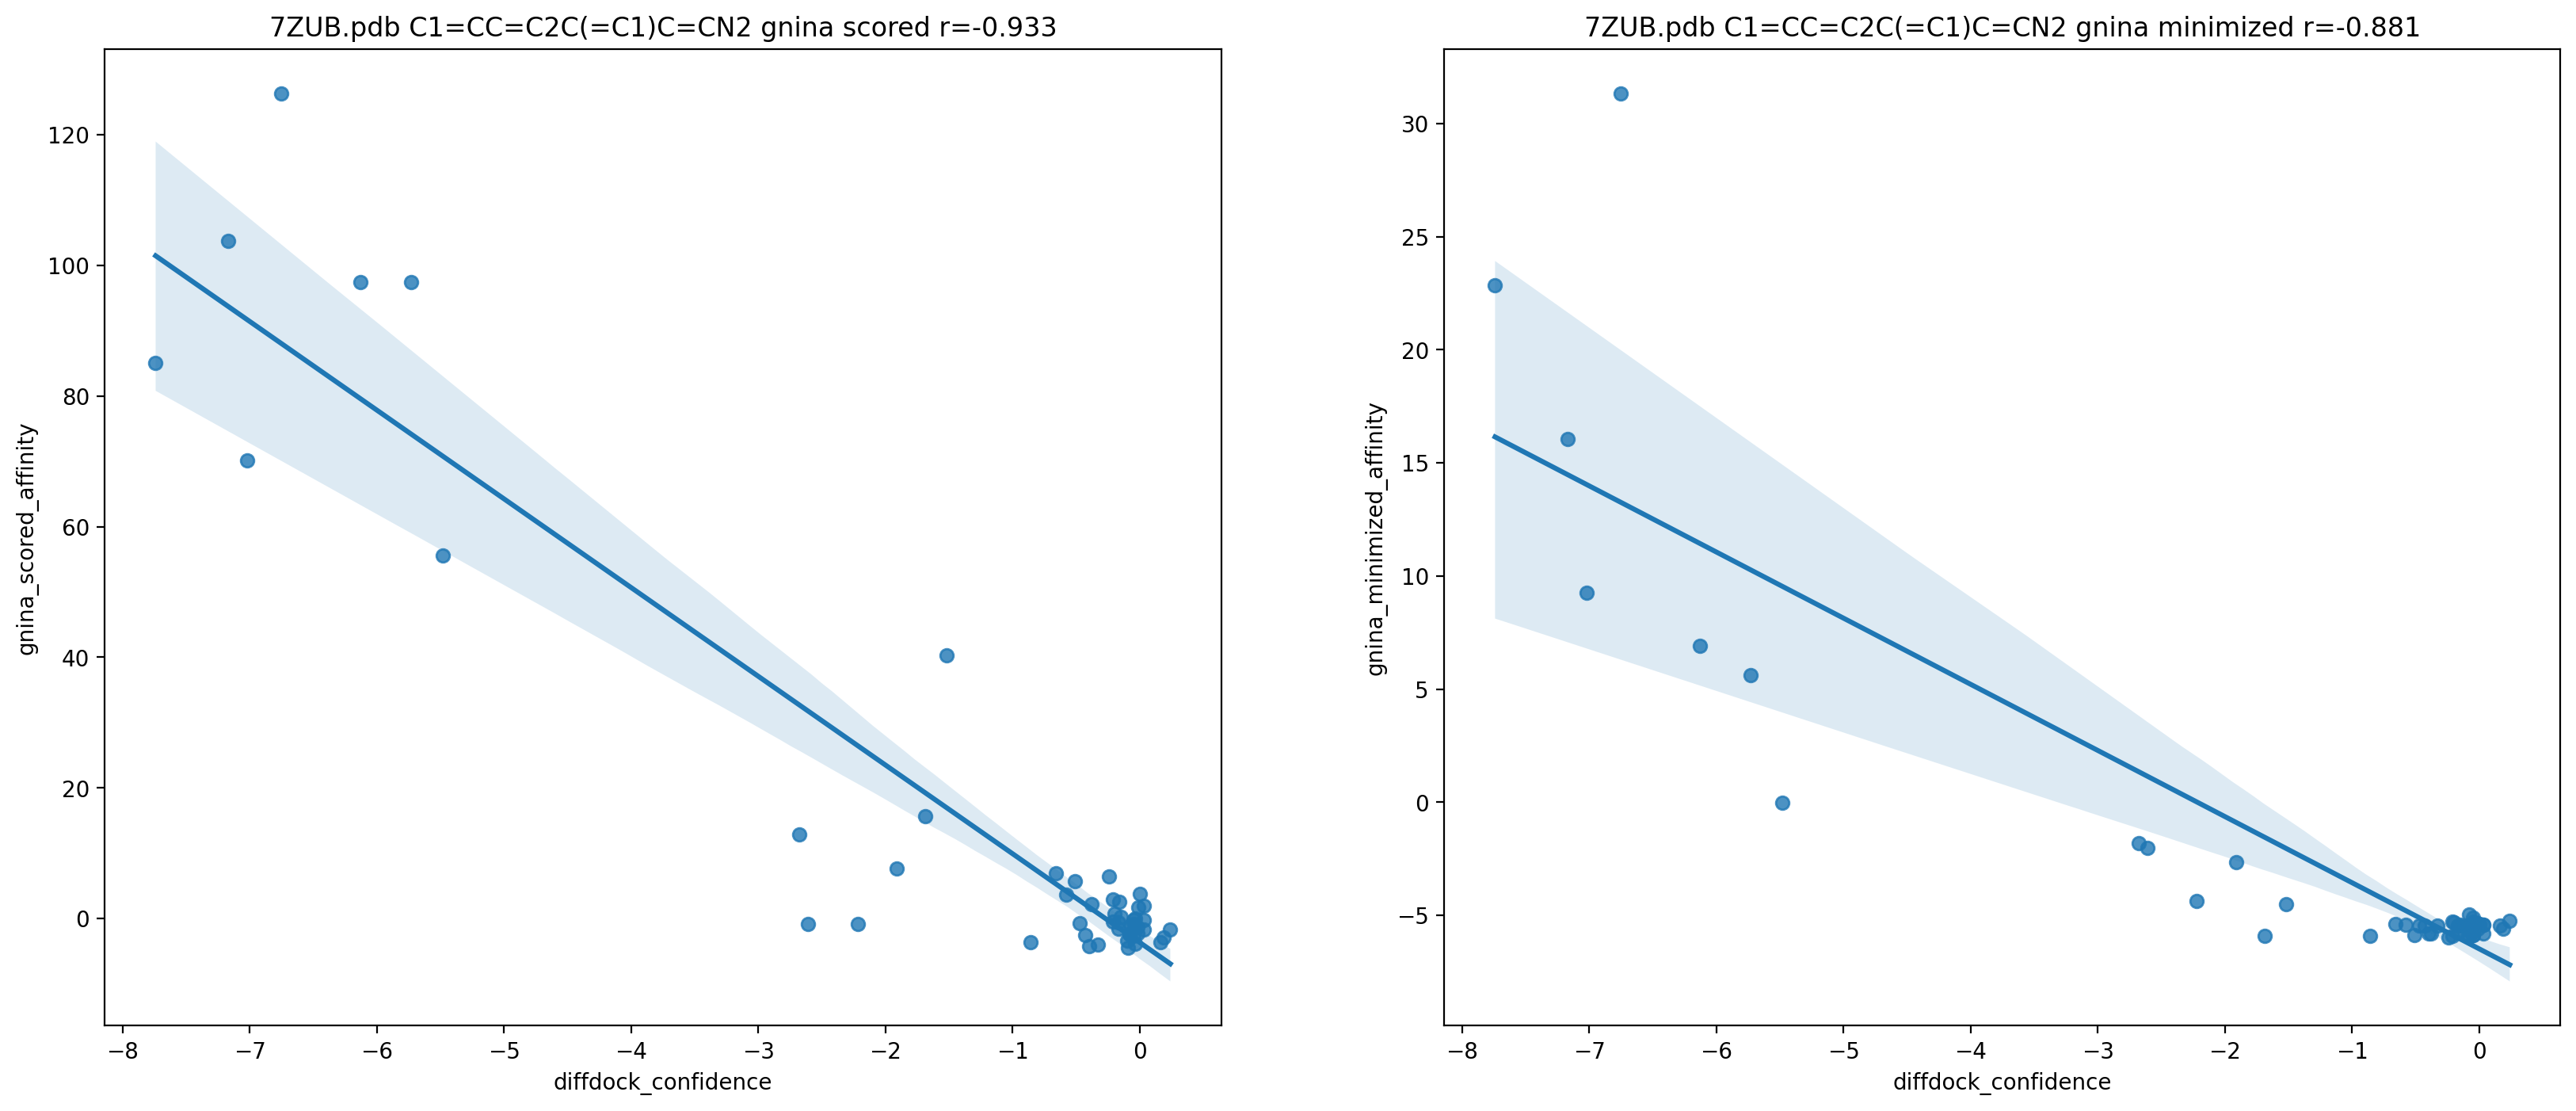

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

# Visualize top hit (highest confidence) in 3D

In [78]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});


# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"lightgrey"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"#39FF14"}})
view.addSurface(py3Dmol.SAS, {'opacity': 0.6, 'color': 'lightgrey'}, {"model": 1})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
!python python_scripts/diffdock_wrapper.py \
    --pdb_path /mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/1FAP.pdb\
    --ligand "C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)/C)OC" \
    --tmp_dir "/mnt/nvme0/jbok/tstrun/tmp" \
    --out_dir "/mnt/nvme0/jbok/tstrun/results" \
    --out_name "mtor-1FAP_rapamycin" \
    --gpu_id 6

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2375.
  warnings.warn(
/home/jbok/miniforge3/envs/diffdock/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2488.
  warnings.warn(
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.31it/s]


Transferred model to GPU
Read /mnt/nvme0/jbok/tstrun/tmp/mtor-1FAP_rapamycin/mtor-1FAP_rapamycin.fa with 2 sequences
Processing 1 of 1 batches (2 sequences)
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings3834535604/heterographs.pkl
Number of complexes:  1
radius protein: mean 30.919404983520508, std 0.0, max 30.919404983520508
radius molecule: mean 10.696349143981934, std 0.0, max 10.696349143981934
distance protein-mol: mean 44.939579010009766, std 0.0, max 44.939579010009766
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data for the confidence model now.
loading data from memory:  data/cache_torsion_allatoms/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_atomRad5_atomMax8_esmEmbeddings3834535604/heterographs.pkl
Number of complexes:  1
radius protein: mean 30.919404983520508, std 0.0, max 30.91940498352

In [24]:
def run_diffdock(pdb_path, ligand, tmp_dir, out_dir, out_name, gpu_id):
    command = f"python python_scripts/diffdock_wrapper.py " \
              f"--pdb_path {pdb_path} " \
              f"--ligand \"{ligand}\" " \
              f"--tmp_dir \"{tmp_dir}\" " \
              f"--out_dir \"{out_dir}\" " \
              f"--out_name \"{out_name}\" " \
              f"--gpu_id {gpu_id}"
    os.system(command)
    
def worker(pair, gpu_id):
    name, pdb_path, ligand = pair
    tmp_dir = "/mnt/nvme0/jbok/tstrun/tmp"
    out_dir = "/mnt/nvme0/jbok/tstrun/results"
    out_name = f"{pdb_path.split('/')[-1].split('.')[0]}_{ligand[:10]}"  # Example out_name based on pdb and ligand
    run_diffdock(pdb_path, ligand, tmp_dir, out_dir, out_name, gpu_id)

In [38]:

# pdb_ligand_pairs = [
#     ("sema_test1", "/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/7KI0.pdb", "CC[C@H](C)[C@@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CNC2=CC=CC=C21)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)O)NC(=O)[C@H](CC3=CC=CC=C3)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@H](C(=O)O)NC(=O)CCCCCCCCCCCCCCCCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)N)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC4=CC=C(C=C4)O)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC5=CC=CC=C5)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)C(C)(C)NC(=O)[C@H](CC6=CN=CN6)N"),
#     ("sema_test2", "/mnt/nvme0/jbok/docking/DiffDock/tmp/pdb/7KI0.pdb", "CC[C@H](C)[C@@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CNC2=CC=CC=C21)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)O)NC(=O)[C@H](CC3=CC=CC=C3)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@H](C(=O)O)NC(=O)CCCCCCCCCCCCCCCCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)N)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC4=CC=C(C=C4)O)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC5=CC=CC=C5)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)C(C)(C)NC(=O)[C@H](CC6=CN=CN6)N"),
#     # Add more pairs as needed
# ]

pdb_ligand_pairs = [
    ("a", "b", "c"),
    ("d", "e", "f")
]

# pdb_ligand_pairs
t1, t2, t3 = pdb_ligand_pairs
print(t1)
print(t3)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import multiprocessing


# Create a pool of 8 workers (for 8 GPUs)
pool = multiprocessing.Pool(8)

# Distribute the work
# Each worker gets a pair and a corresponding GPU ID (0-7)
pool.starmap(worker, [(pair, i % 8) for i, pair in enumerate(pdb_ligand_pairs)])
